In [2]:
### Cell was executed again in the end to get rid of warning with path information that might have disclosed identity
import sys
# Append root path 
sys.path.append("../")
sys.path.append("../lmmnn")
sys.path.append("../ARMED-MixedEffectsDL")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

import time

from armed.models.mlp_classifiers import SimchoniMixedEffectsMLP
from model.mixed_effects import *

from utils.fe_models import get_model
from utils.evaluation import *
from utils.utils import *
from data.preprocessing import dataset_preprocessing

from vis.utils.utils import apply_modifications
# helper function
def update_layer_activation(model, activation, index=-1):
    model.layers[index].activation = activation
    return apply_modifications(model)

from lmmnn.utils import generate_data
from lmmnn.nn import reg_nn_lmm

from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Reshape, Embedding, Concatenate
from tensorflow.keras.activations import sigmoid

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_auc_score as auroc
from sklearn.metrics import f1_score as f1
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from tensorflow_addons.metrics import F1Score

from scipy import stats
import pickle
import yaml
import gc

RS = 1

SUCCESS: Found GPU: /device:GPU:0


In [3]:
iterations = 5

params = {
    "n_fixed_effects": 10,
    "fixed_intercept": 1,
    "X_non_linear": True,
    "Z_non_linear": False,
    "Z_embed_dim_pct": 10,
    "n_per_cat": 3,
    "test_size": 0.2,
}


N = 100000
d = params["n_fixed_effects"]
q_list = [100, 1000,10000]
sig2b_list = [0.1, 1.0, 10.0]
mode = "glmm"

#!!! Requires to add b_hat to the generate_data function from utils.py in the lmmnn repository
datasets = {}
scenarios = []
for sig2b in sig2b_list:
    for q in q_list:
        datasets[f"{sig2b},{q}"] = {}
        for num in range(5):
            np.random.seed(RS+num)
            tf.random.set_seed(RS+num)
            datasets[f"{sig2b},{q}"][num] = generate_data(mode=mode, qs=[q], sig2e=1.0, sig2bs=[sig2b], sig2bs_spatial=[], q_spatial=[], N=N, rhos=None, p_censor=None, params=params)
            
        scenarios.append(f"{sig2b},{q}")


In [4]:
experiment_name = "simchoni_binary_test"
if not os.path.exists(f"../results/{experiment_name}"):
    os.mkdir(f"../results/{experiment_name}")
    

In [5]:
loss_use = lambda: tf.keras.losses.BinaryCrossentropy

target= "binary"
batch_size=100
epochs = 200
early_stopping = 5
model_name = "simchoni_2021"
embed_dims_method = "AutoGluon"

results = {}


for scenario_num, scenario_key in enumerate(scenarios):
    N = 100000
    d = 10
    n_classes = 1
    qs = [int(scenarios[0].split(",")[1])]
    sig2bs =[float(scenarios[0].split(",")[0])]
    
    results[scenario_key] = {}
    for num in range(iterations):
        if not os.path.exists(f"../results/{experiment_name}/results_RS{RS}_{scenario_key}_iter{num}.pickle"):

            results[scenario_key][num] = {}

            tf.random.set_seed(RS+num)
            np.random.seed(RS+num)

            print(f"Start modeling for scenario {scenario_key}, iteration={num}")
            X_train, X_test, y_train, y_test, x_cols, dist_matrix, time2measure_dict, b_true = datasets[scenario_key][num]

            z_cols = sorted(list(set(X_train.columns)-set(x_cols)))#[f"z{i}" for i in range(len(qs))]
            cols = X_train.columns

            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
            X_train_lmmnn, X_val_lmmnn, X_test_lmmnn, y_train_lmmnn, y_val_lmmnn, y_test_lmmnn  = X_train.reset_index(drop=True), X_val.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_val.reset_index(drop=True), y_test.reset_index(drop=True) 

            
            X_train = pd.DataFrame(X_train,columns=cols)
            X_val = pd.DataFrame(X_val,columns=cols)

            Z_train = X_train[z_cols].values
            X_train = X_train[x_cols].astype(np.float32)
            y_train = y_train.astype(np.float32)

            Z_val = X_val[z_cols].values
            X_val = X_val[x_cols].astype(np.float32)
            y_val = y_val.astype(np.float32)

            Z_test = X_test[z_cols].values
            X_test = X_test[x_cols].astype(np.float32)
            y_test = y_test.astype(np.float32)

            qs = np.max([tf.reduce_max(Z_train, axis=0),tf.reduce_max(Z_val, axis=0),tf.reduce_max(Z_test, axis=0)],axis=0)+1
            
            # Unregularized target encoding
            start = time.time()
            encoder = TargetEncoder()
            z_target_encoded_train = encoder.fit_transform(Z_train.astype(object), y_train).values # fit_transform on train data
            z_target_encoded_val = encoder.transform(Z_val.astype(object)).values # transform on test data
            z_target_encoded_test = encoder.transform(Z_test.astype(object)).values # transform on test data
            end = time.time()
            target_encoding_time = end-start

            # OHE        
            start = time.time()
            z_ohe_encoded_train = np.concatenate([tf.one_hot(Z_train[:,num],qs[num]).numpy() for num in range(len(qs))],axis=1)
            z_ohe_encoded_val = np.concatenate([tf.one_hot(Z_val[:,num],qs[num]).numpy() for num in range(len(qs))],axis=1)
            z_ohe_encoded_test = np.concatenate([tf.one_hot(Z_test[:,num],qs[num]).numpy() for num in range(len(qs))],axis=1)
            ohe_encoding_time = end-start
            ohe_encoding_time


            X_train = tf.convert_to_tensor(X_train)
            Z_train = tf.convert_to_tensor(Z_train,dtype=tf.int32)
            y_train = tf.convert_to_tensor(y_train)

            X_val = tf.convert_to_tensor(X_val)
            Z_val = tf.convert_to_tensor(Z_val,dtype=tf.int32)
            y_val = tf.convert_to_tensor(y_val)

            X_test = tf.convert_to_tensor(X_test)
            Z_test = tf.convert_to_tensor(Z_test,dtype=tf.int32)
            y_test = tf.convert_to_tensor(y_test)

            ##### GMENN #####
            if target == "categorical":
                n_classes = np.unique(y_train).shape[0]
            elif target=="binary":
                n_classes = 1
            
            y_train = tf.one_hot(tf.cast(y_train,tf.int32),n_classes)
            y_val = tf.one_hot(tf.cast(y_val,tf.int32),n_classes)
            y_test = tf.one_hot(tf.cast(y_test,tf.int32),n_classes)

            d = X_train.shape[1] # columns
            n = X_train.shape[0] # rows
            num_outputs = n_classes
            perc_numeric = d/(d+Z_train.shape[1])

#             qs = np.max([tf.reduce_max(Z_train, axis=0),tf.reduce_max(Z_val, axis=0),tf.reduce_max(Z_test, axis=0)],axis=0)+1

            set_seed(RS)

            fe_model, optimizer = get_model(model_name=model_name, input_size=X_train.shape[1], 
                                              output_size=num_outputs, 
                                              target=target, 
                                              perc_numeric=perc_numeric, RS=RS)

            initial_stds = np.ones([len(qs),num_outputs]).astype(float).tolist()

            me_model = MixedEffectsNetwork(X_train, Z_train, y_train, fe_model, 
                                           target=target, qs=qs,
                                           initial_stds=initial_stds,
                                          fe_loss_weight=1.,
                                           mode="intercepts",
                                           early_stopping_fe=early_stopping,
                                          )    

            me_model.compile(
                loss_class_me = loss_use()(),
                loss_class_fe = loss_use()(),
            #     metric_class_me = tf.keras.metrics.AUC(multi_label=True, name="auc_me"),
            #     metric_class_fe = tf.keras.metrics.AUC(multi_label=True, name="auc_fe"),
                optimizer=optimizer
            )

            mcmc = MCMCSamplingCallback(num_mcmc_samples=1,
                                        perc_burnin=0.7,
                                        warm_restart=None,
                                        num_burnin_steps=1,
                                        step_size = 0.1#initial_step_size,
                                   )

            print_metric = PrintMetrics(X_train, Z_train, y_train, X_val, Z_val, y_val)

            start = time.time()
            history = me_model.fit([X_train,Z_train], y_train,
                         callbacks=[mcmc,
                                    print_metric,
                                    tf.keras.callbacks.EarlyStopping(monitor="me_auc_val", patience=early_stopping, mode="max")],
                         epochs=epochs,
                         validation_data=[[X_val,Z_val],y_val],
                        batch_size=batch_size)

            end = time.time()
            fit_time_gmenn = round(end-start,2)

            y_train_pred_gmenn, y_train_pred_gmenn_fe = me_model([X_train,Z_train])
            y_val_pred_gmenn, y_val_pred_gmenn_fe = me_model([X_val,Z_val])
            y_test_pred_gmenn, y_test_pred_gmenn_fe = me_model([X_test,Z_test])    

            gc.collect()

            ###### Prepare NN Training ######
            metrics_use = []
            if target =="binary":
                metrics_use.append(tf.keras.metrics.AUC(name="auc"))
                metrics_use.append(tf.keras.metrics.Accuracy(name="accuracy"))
                metrics_use.append(F1Score(num_classes=2, average="micro", name="f1"))
                stop_mode = "max"
                activation_layer = tf.keras.activations.sigmoid
            elif target =="categorical":
                metrics_use.append(tf.keras.metrics.AUC(multi_label=True, name="auc"))
                metrics_use.append(tf.keras.metrics.CategoricalAccuracy(name="accuracy"))
                metrics_use.append(F1Score(num_classes=num_outputs, average="weighted", name="f1"))
                stop_mode = "max"
                activation_layer = tf.keras.activations.softmax
            elif target == "continuous":
                metrics_use.append(RSquare(name="r2"))
                metrics_use.append(tf.keras.metrics.MeanSquaredError(name="mse"))
                stop_mode = "min"            
            
            ##### Ignore #####
            model_nn, optimizer = get_model(model_name=model_name, 
                                            input_size=X_train.shape[1], 
                                            output_size=num_outputs, 
                                            target=target, 
                                            perc_numeric=perc_numeric, RS=RS)
            model_nn.build((n,d))
            update_layer_activation(model=model_nn, activation=activation_layer)

            model_nn.compile(loss=loss_use()(), optimizer=optimizer, metrics = metrics_use)

            callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=early_stopping, mode=stop_mode)

            start = time.time()
            history_nn = model_nn.fit(X_train, y_train,
                         validation_data= [X_val, y_val],
                         epochs=epochs, batch_size=batch_size, callbacks=[callback])
            end = time.time()
            fit_time_nn = round(end-start,2)

            y_train_pred_nn = model_nn.predict(X_train ,batch_size=batch_size)
            y_val_pred_nn = model_nn.predict(X_val ,batch_size=batch_size)
            y_test_pred_nn = model_nn.predict(X_test ,batch_size=batch_size)

            if target == "binary":
                eval_res_train_nn = get_metrics(y_train[:,0], y_train_pred_nn, target=target)
                eval_res_val_nn = get_metrics(y_val[:,0], y_val_pred_nn, target=target)
                eval_res_test_nn = get_metrics(y_test[:,0], y_test_pred_nn, target=target)
            elif target == "categorical":
                eval_res_train_nn = get_metrics(y_train, y_train_pred_nn, target=target)
                eval_res_val_nn = get_metrics(y_val, y_val_pred_nn, target=target)
                eval_res_test_nn = get_metrics(y_test, y_test_pred_nn, target=target)

            ##### Target Encoding #####
            print("\n Train Target Encoding Network")
            model_nn_te, optimizer = get_model(model_name=model_name, 
                                            input_size=np.append(X_train ,z_target_encoded_train, axis=1).shape[1], 
                                            output_size=num_outputs, 
                                            target=target, 
                                            perc_numeric=perc_numeric, RS=RS)
            model_nn_te.build((n,np.append(X_train ,z_target_encoded_train, axis=1).shape[1]))
            update_layer_activation(model=model_nn_te, activation=activation_layer)
            model_nn_te.compile(loss=loss_use()(), optimizer=optimizer, metrics = metrics_use)
            callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=early_stopping, mode=stop_mode)

            start = time.time()
            history_nn_te = model_nn_te.fit(np.append(X_train ,z_target_encoded_train, axis=1), y_train,
                         validation_data= [np.append(X_val ,z_target_encoded_val, axis=1), y_val],
                         epochs=epochs, batch_size=batch_size, callbacks=[callback])
            end = time.time()
            fit_time_te = round(end-start,2)+target_encoding_time

            y_train_pred_nn_te = model_nn_te.predict(np.append(X_train ,z_target_encoded_train, axis=1) ,batch_size=batch_size)
            y_val_pred_nn_te = model_nn_te.predict(np.append(X_val ,z_target_encoded_val, axis=1) ,batch_size=batch_size)
            y_test_pred_nn_te = model_nn_te.predict(np.append(X_test ,z_target_encoded_test, axis=1) ,batch_size=batch_size)

            if target == "binary":
                eval_res_train_nn_te = get_metrics(y_train[:,0], y_train_pred_nn_te, target=target)
                eval_res_val_nn_te = get_metrics(y_val[:,0], y_val_pred_nn_te, target=target)
                eval_res_test_nn_te = get_metrics(y_test[:,0], y_test_pred_nn_te, target=target)
            elif target == "categorical":
                eval_res_train_nn_te = get_metrics(y_train, y_train_pred_te, target=target)
                eval_res_val_nn_te = get_metrics(y_val, y_val_pred_te, target=target)
                eval_res_test_nn_te = get_metrics(y_test, y_test_pred_te, target=target)


            ##### OHE #####
            print("\n Train OHE Network")
            model_nn_ohe, optimizer = get_model(model_name=model_name, 
                                            input_size=np.append(X_train ,z_ohe_encoded_train, axis=1).shape[1], 
                                            output_size=num_outputs, 
                                            target=target, 
                                            perc_numeric=perc_numeric, RS=RS)
            model_nn_ohe.build((n,np.append(X_train ,z_ohe_encoded_train, axis=1).shape[1]))
            update_layer_activation(model=model_nn_ohe, activation=activation_layer)
            model_nn_ohe.compile(loss=loss_use()(), optimizer=optimizer, metrics = metrics_use)
            callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=early_stopping, mode=stop_mode)

            start = time.time()
            history_nn_ohe = model_nn_ohe.fit(np.append(X_train ,z_ohe_encoded_train, axis=1), y_train,
                         validation_data= [np.append(X_val ,z_ohe_encoded_val, axis=1), y_val],
                         epochs=epochs, batch_size=batch_size, callbacks=[callback])
            end = time.time()
            fit_time_ohe = round(end-start,2)+ohe_encoding_time

            y_train_pred_nn_ohe = model_nn_ohe.predict(np.append(X_train ,z_ohe_encoded_train, axis=1), batch_size=batch_size)
            y_val_pred_nn_ohe = model_nn_ohe.predict(np.append(X_val ,z_ohe_encoded_val, axis=1), batch_size=batch_size)
            y_test_pred_nn_ohe = model_nn_ohe.predict(np.append(X_test ,z_ohe_encoded_test, axis=1), batch_size=batch_size)
            
            if target == "binary":
                eval_res_train_nn_ohe = get_metrics(y_train[:,0], y_train_pred_nn_ohe, target=target)
                eval_res_val_nn_ohe = get_metrics(y_val[:,0], y_val_pred_nn_ohe, target=target)
                eval_res_test_nn_ohe = get_metrics(y_test[:,0], y_test_pred_nn_ohe, target=target)            
            elif target == "categorical":
                eval_res_train_nn_ohe = get_metrics(y_train, y_train_pred_nn_ohe, target=target)
                eval_res_val_nn_ohe = get_metrics(y_val, y_val_pred_nn_ohe, target=target)
                eval_res_test_nn_ohe = get_metrics(y_test, y_test_pred_nn_ohe, target=target)
            
            gc.collect()
            ##### Embedding #####
            print("\n Embedding Estimate Network")

            if embed_dims_method=="sqrt":
                embed_dims = [int(np.sqrt(q)) for q in qs]
            elif embed_dims_method=="AutoGluon":
                embed_dims = [int(np.max([100, np.round(1.6*q**0.56)])) for q in qs]
            else:
                embed_dims = [10 for q in qs]

            input_layer = Input(shape=(d,))

            # Define embedding layers
            embed_inputs = []
            embedding_layers = []
            for q_num in range(len(qs)):
                Z_input_layer = Input(shape=(1,))
                embedding_layer = Embedding(qs[q_num], embed_dims[q_num], input_length=1)(Z_input_layer)
                embedding_layer = Reshape(target_shape=(embed_dims[q_num],))(embedding_layer)

                embed_inputs.append(Z_input_layer)
                embedding_layers.append(embedding_layer)

            ### Get model layer dimensions
            min_numeric_embed_dim = 32
            max_numeric_embed_dim = 2056
            max_layer_width = 2056
            # Main dense model
            if target == "continuous":
                default_layer_sizes = [256,
                                       128]  # overall network will have 4 layers. Input layer, 256-unit hidden layer, 128-unit hidden layer, output layer.
            else:
                default_sizes = [256, 128]  # will be scaled adaptively
                # base_size = max(1, min(num_net_outputs, 20)/2.0) # scale layer width based on number of classes
                base_size = max(1, min(num_outputs,
                                       100) / 50)  # TODO: Updated because it improved model quality and made training far faster
                default_layer_sizes = [defaultsize * base_size for defaultsize in default_sizes]
            layer_expansion_factor = 1  # TODO: consider scaling based on num_rows, eg: layer_expansion_factor = 2-np.exp(-max(0,train_dataset.num_examples-10000))
            first_layer_width = int(min(max_layer_width, layer_expansion_factor * default_layer_sizes[0]))

            # numeric embed dim
            vector_dim = 0  # total dimensionality of vector features (I think those should be transformed string features, which we don't have)
            prop_vector_features = perc_numeric  # Fraction of features that are numeric
            numeric_embedding_size = int(min(max_numeric_embed_dim,
                                             max(min_numeric_embed_dim,
                                                 first_layer_width * prop_vector_features * np.log10(vector_dim + 10))))


            numeric_embedding = Dense(numeric_embedding_size, activation="relu")(input_layer)

            concat = Concatenate()([numeric_embedding] + embedding_layers)

            base_model, optimizer = get_model(model_name=model_name, 
                                              input_size=numeric_embedding_size + sum(embed_dims), 
                                              output_size=num_outputs, target=target,
                                              perc_numeric=perc_numeric, RS=RS)

            base_model.build((n, numeric_embedding_size + sum(embed_dims)))
            update_layer_activation(model=base_model, activation=activation_layer)

            layers = base_model(concat)

            model_embed = Model(inputs=[input_layer] + embed_inputs, outputs=layers)


            model_embed.compile(loss=loss_use()(), optimizer=optimizer, metrics = metrics_use)
            callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=early_stopping, mode=stop_mode)

            start = time.time()
            history_nn_embed = model_embed.fit([X_train] + [Z_train[: ,q_num] for q_num in range(len(qs))], y_train,
                            validation_data=[[X_val] + [Z_val[: ,q_num] for q_num in range(len(qs))], y_val],
                            epochs=epochs, batch_size=batch_size, callbacks=[callback])
            end = time.time()
            fit_time_embed = round(end-start,2)

            y_train_pred_embed = model_embed.predict([X_train] + [Z_train[: ,q_num] for q_num in range(len(qs))]
                                                     ,batch_size=batch_size)
            y_val_pred_embed = model_embed.predict([X_val] + [Z_val[: ,q_num] for q_num in range(len(qs))]
                                                    ,batch_size=batch_size)
            y_test_pred_embed = model_embed.predict([X_test] + [Z_test[: ,q_num] for q_num in range(len(qs))]
                                                    ,batch_size=batch_size)

            if target == "binary":
                eval_res_train_embed = get_metrics(y_train[:,0], y_train_pred_embed, target=target)
                eval_res_val_embed = get_metrics(y_val[:,0], y_val_pred_embed, target=target)
                eval_res_test_embed = get_metrics(y_test[:,0], y_test_pred_embed, target=target)
            elif target == "categorical":
                eval_res_train_embed = get_metrics(y_train, y_train_pred_embed, target=target)
                eval_res_val_embed = get_metrics(y_val, y_val_pred_embed, target=target)
                eval_res_test_embed = get_metrics(y_test, y_test_pred_embed, target=target)

            eval_res_train_embed, eval_res_test_embed        


            
            ##### LMMNN #####
            try:
                if target=="binary":
                    num_outputs = 1

                print(f"Train LMMNN")
                mode = 'glmm'

                qs_lmmnn = [i.max()+1 for i in np.concatenate([Z_train,Z_val,Z_test]).transpose()]

                start = time.time()
                model_lmmnn_fe, optimizer = get_model(model_name=model_name, input_size=d,
                                                      output_size=num_outputs, RS=RS)

    #             x_cols = list(X_train.columns)
                q_spatial =[]
                n_neurons = [100, 50]
                dropout = None
                activation = 'relu'
                n_sig2bs = len(qs_lmmnn)
                n_sig2bs_spatial = 0
                est_cors = []
                dist_matrix = None
                time2measure_dict = None
                spatial_embed_neurons = None
                verbose = True
                Z_non_linear = False
                log_params = False
                idx = None
                Z_embed_dim_pct = 10

                y_pred_test_lmmnn, sigmas, rhos, weibull, n_epochs, b_hat, model_lmmnn, y_pred_train_lmmnn = reg_nn_lmm(
                    model_lmmnn_fe, optimizer,
                    X_train_lmmnn, X_val_lmmnn, X_test_lmmnn, y_train_lmmnn, y_val_lmmnn, y_test_lmmnn, qs_lmmnn, q_spatial, x_cols,
                    batch_size, epochs, early_stopping,
                    n_neurons, dropout, activation, mode,
                    n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons, verbose, Z_non_linear,
                    Z_embed_dim_pct, log_params, idx)
                end = time.time()
                fit_time_lmmnn = round(end-start,2)

                y_train_pred_lmmnn_fe = model_lmmnn.predict \
                    ([X_train, np.zeros(y_train_lmmnn.shape[0]), [Z_train[: ,num] for num in range(len(qs_lmmnn))]], batch_size = batch_size).ravel()
                y_val_pred_lmmnn_fe = model_lmmnn.predict \
                    ([X_val, np.zeros(y_val_lmmnn.shape[0]), [Z_val[: ,num] for num in range(len(qs_lmmnn))]], batch_size = batch_size).ravel()
                y_test_pred_lmmnn_fe = model_lmmnn.predict \
                    ([X_test, np.zeros(y_test_lmmnn.shape[0]), [Z_test[: ,num] for num in range(len(qs_lmmnn))]], batch_size = batch_size).ravel()

                b_hats = [b_hat[:qs_lmmnn[num]] if num == 0 else b_hat[sum(qs_lmmnn[:num]):] if num==len(qs_lmmnn) -1 else b_hat[sum(qs_lmmnn[:num]):sum
                    (qs_lmmnn[:num] ) +qs_lmmnn[num]] for num in range(len(qs_lmmnn))]

                y_train_pred_lmmnn = y_train_pred_lmmnn_fe + tf.reduce_sum([tf.gather(b_hat, Z_train[: ,num]) for num, b_hat in enumerate(b_hats)], axis=0).numpy()
                y_val_pred_lmmnn = y_val_pred_lmmnn_fe + tf.reduce_sum([tf.gather(b_hat, Z_val[: ,num]) for num, b_hat in enumerate(b_hats)], axis=0).numpy()
                y_test_pred_lmmnn = y_test_pred_lmmnn_fe + tf.reduce_sum([tf.gather(b_hat, Z_test[: ,num]) for num, b_hat in enumerate(b_hats)], axis=0).numpy()
                if target == "binary":
                    y_train_pred_lmmnn = sigmoid(y_train_pred_lmmnn)
                    y_val_pred_lmmnn = sigmoid(y_val_pred_lmmnn)
                    y_test_pred_lmmnn = sigmoid(y_test_pred_lmmnn)
                    y_train_pred_lmmnn_fe = sigmoid(y_train_pred_lmmnn_fe)
                    y_val_pred_lmmnn_fe = sigmoid(y_val_pred_lmmnn_fe)
                    y_test_pred_lmmnn_fe = sigmoid(y_test_pred_lmmnn_fe)

                eval_res_train_lmmnn = get_metrics(y_train, y_train_pred_lmmnn, target=target)
                eval_res_test_lmmnn = get_metrics(y_test, y_test_pred_lmmnn, target=target)

                eval_res_train_fe_lmmnn = get_metrics(y_train, y_train_pred_lmmnn_fe, target=target)
                eval_res_test_fe_lmmnn = get_metrics(y_test, y_test_pred_lmmnn_fe, target=target)

    #             model_lmmnn_info = {"sigmas": sigmas,
    #                                 "b_hats": b_hats}




                gc.collect()
            except:
                print(f"LMMNN failed")
                n_epochs = None
                y_train_pred_nn_lmmnn = None
                y_val_pred_nn_lmmnn = None
                y_test_pred_nn_lmmnn = None
                fit_time_lmmnn = None

            ##### ARMED (no adversarial reg.)#####
            _, optimizer = get_model(model_name=model_name, 
                                input_size=X_train.shape[1], 
                                output_size=num_outputs, 
                                target=target, 
                                perc_numeric=perc_numeric, RS=RS)
        
            dictBuild = {'n_features': X_train.shape[1],
                         'n_clusters': qs[0],
                         'adversary_layer_units': [4, 4],
            #              'slope_posterior_init_scale': 0.1, 
                         'intercept_posterior_init_scale': 0.1, 
            #              'slope_prior_scale': 0.15, 
                         'intercept_prior_scale': 0.1,
                         'kl_weight': 0.00001}
            dictCompile = {'loss_class_fe_weight': 1.0, 
                           'loss_gen_weight': 0.0, 
                           'loss_class_me_weight': 1.0,
                           "opt_main": optimizer
            #               'opt_adversary': tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
                          }

            model_armed_noadv = SimchoniMixedEffectsMLP(**dictBuild)

            model_armed_noadv.compile(**dictCompile)

            # print_metric = PrintOwnMetricsArmed(X_train_armed, Z_train_armed, y_train_armed, X_val_armed, Z_val_armed, y_val_armed)

            lsCallbacks = [#print_metric,
                           tf.keras.callbacks.EarlyStopping(monitor='val_auc', 
                                                            mode='max',
                                                            patience=early_stopping, 
                                                            restore_best_weights=False)]

            start = time.time()
            history_armed_noadv = model_armed_noadv.fit((X_train,z_ohe_encoded_train), y_train,
                            validation_data=((X_val,z_ohe_encoded_val), y_val),
                            callbacks=lsCallbacks,
                            epochs=epochs,
                            batch_size=batch_size,                
                            verbose=1,
            #                 class_weight=dictClassWeights
                           )
            end = time.time()
            fit_time_armed_noadv = round(end-start,2)

            train_pred_armed_noadv, train_pred_armed_noadv_fe, train_pred_cluster_armed_noadv = model_armed_noadv.predict((X_train,z_ohe_encoded_train))
            val_pred_armed_noadv, val_pred_armed_noadv_fe, val_pred_cluster_armed_noadv = model_armed_noadv.predict((X_val,z_ohe_encoded_val))
            test_pred_armed_noadv, test_pred_armed_noadv_fe, test_pred_cluster_armed_noadv = model_armed_noadv.predict((X_test,z_ohe_encoded_test))

            train_res_armed_noadv = get_metrics(y_train,train_pred_armed_noadv,"binary")
            val_res_armed_noadv = get_metrics(y_val,val_pred_armed_noadv,"binary")
            test_res_armed_noadv = get_metrics(y_test,test_pred_armed_noadv,"binary")

            train_res_armed_noadv_fe = get_metrics(y_train,train_pred_armed_noadv_fe,"binary")
            val_res_armed_noadv_fe = get_metrics(y_val,val_pred_armed_noadv_fe,"binary")
            test_res_armed_noadv_fe = get_metrics(y_test,test_pred_armed_noadv_fe,"binary")



            ##### Document Results #####
            
            results[scenario_key][num]["histories"] = {"GMENN": history.history,
                                                       "Ignore": history_nn.history,
                                                       "TE": history_nn_te.history,
                                                       "OHE": history_nn_ohe.history,
                                                       "Embedding": history_nn_embed.history,
                                                       "LMMNN": [n_epochs],
#                                                        "ARMED": history_armed.history,
                                                       "ARMED (no adv.)": history_armed_noadv.history,
                                                      }
            
            results[scenario_key][num]["predictions"] = {"GMENN": [y_train_pred_gmenn, y_val_pred_gmenn, y_test_pred_gmenn],
                                                        "GMENN (FE)": [y_train_pred_gmenn_fe, y_val_pred_gmenn_fe, y_test_pred_gmenn_fe],
                                                        "Ignore": [y_train_pred_nn, y_val_pred_nn, y_test_pred_nn],
                                                        "TE": [y_train_pred_nn_te, y_val_pred_nn_te, y_test_pred_nn_te],
                                                        "OHE": [y_train_pred_nn_ohe, y_val_pred_nn_ohe, y_test_pred_nn_ohe],
                                                        "Embedding": [y_train_pred_embed, y_val_pred_embed, y_test_pred_embed],
                                                        "LMMNN": [y_train_pred_lmmnn, y_val_pred_lmmnn, y_test_pred_lmmnn],
                                                        "LMMNN (FE)": [y_train_pred_lmmnn_fe, y_val_pred_lmmnn_fe, y_test_pred_lmmnn_fe],
#                                                         "ARMED": [train_pred_armed, val_pred_armed, test_pred_armed],
#                                                         "ARMED (FE)": [train_pred_armed_fe, val_pred_armed_fe, test_pred_armed_fe],
                                                        "ARMED (no adv.)": [train_pred_armed_noadv, val_pred_armed_noadv, test_pred_armed_noadv],
                                                        "ARMED (no adv.) (FE)": [train_pred_armed_noadv_fe, val_pred_armed_noadv_fe, test_pred_armed_noadv_fe],
                                                      }
            
            results[scenario_key][num]["times"] = {"GMENN": fit_time_gmenn,
                                                   "Ignore": fit_time_nn,
                                                   "TE": fit_time_te,
                                                   "OHE": fit_time_ohe,
                                                   "Embedding": fit_time_embed,
                                                   "LMMNN": fit_time_lmmnn,
#                                                    "ARMED": fit_time_armed,
                                                   "ARMED (no adv.)": fit_time_armed_noadv,
                                                      }
            
            results[scenario_key][num]["other_info"] = {
                "GMENN": {
                    "_stddev_z": np.array([i.numpy() for i in me_model.data_model._stddev_z]),
                    "acceptance_rates": np.array(me_model.acceptance_rates),
                    "random_effects": me_model.mean_samples,
                    "all_samples": me_model.all_samples,
                    "stds": me_model.stds
                },
                "LMMNN": {
                    "_stddev_z": sigmas,
                    "random_effects": b_hats,
                },
#                 "ARMED": {
#                     "_stddev_z": np.std(model_armed.randomeffects.re_int.weights[0].numpy()[:qs[0]]),
#                     "random_effects": model_armed.randomeffects.re_int.weights[0].numpy()[:qs[0]],
# #                     "pred_cluster": [train_pred_cluster_armed,val_pred_cluster_armed,test_pred_cluster_armed]
#                 },
                "ARMED (no adv.)": {
                    "_stddev_z": np.std(model_armed_noadv.randomeffects.re_int.weights[0].numpy()[:qs[0]]),
                    "random_effects": model_armed_noadv.randomeffects.re_int.weights[0].numpy()[:qs[0]],
#                     "pred_cluster": [train_pred_cluster_armed_noadv,val_pred_cluster_armed_noadv,test_pred_cluster_armed_noadv]
                }
            }
            
#             del model_lmmnn, model_lmmnn_fe
            
            with open(f"../results/{experiment_name}/results_RS{RS}_{scenario_key}_iter{num}.pickle", 'wb') as handle:
                pickle.dump(results[scenario_key][num], handle, protocol=pickle.HIGHEST_PROTOCOL)
            
            
            del X_train, X_val, X_test, y_train, y_val, y_test
            del z_target_encoded_train, z_target_encoded_val, z_target_encoded_test
            del z_ohe_encoded_train, z_ohe_encoded_val, z_ohe_encoded_test
            del model_armed_noadv, model_lmmnn, model_lmmnn_fe, model_embed, model_nn, model_nn_ohe, model_nn_te
            
            gc.collect()
        else:
            print(f"Scenario {scenario_key}, iteration={num} already trained")
#             with open(f"../results/{experiment_name}/results_RS{RS}_{scenario_key}_iter{num}.pickle", 'rb') as handle:
#                 results[scenario_key][num] = pickle.load(handle)
#                 if qs[0]==10000:
#                     results[scenario_key][num]["other_info"]["ARMED"]["pred_cluster"] = None
#                     results[scenario_key][num]["other_info"]["ARMED (no adv.)"]["pred_cluster"] = None

#           gc.collect()

Scenario 0.1,100, iteration=0 already trained
Scenario 0.1,100, iteration=1 already trained
Scenario 0.1,100, iteration=2 already trained
Scenario 0.1,100, iteration=3 already trained
Scenario 0.1,100, iteration=4 already trained
Scenario 0.1,1000, iteration=0 already trained
Scenario 0.1,1000, iteration=1 already trained
Scenario 0.1,1000, iteration=2 already trained
Scenario 0.1,1000, iteration=3 already trained
Scenario 0.1,1000, iteration=4 already trained
Scenario 0.1,10000, iteration=0 already trained
Scenario 0.1,10000, iteration=1 already trained
Scenario 0.1,10000, iteration=2 already trained
Scenario 0.1,10000, iteration=3 already trained
Scenario 0.1,10000, iteration=4 already trained
Scenario 1.0,100, iteration=0 already trained
Scenario 1.0,100, iteration=1 already trained
Scenario 1.0,100, iteration=2 already trained
Scenario 1.0,100, iteration=3 already trained
Scenario 1.0,100, iteration=4 already trained
Scenario 1.0,1000, iteration=0 already trained
Scenario 1.0,1000,

In [6]:
### Load results
results = {}
for scenario_num, scenario_key in enumerate(scenarios):
    results[scenario_key] = {}
    for num in range(iterations):
        print(f"Load results for scenario {scenario_key}, iteration={num}")
        with open(f"../results/{experiment_name}/results_RS{RS}_{scenario_key}_iter{num}.pickle", 'rb') as handle:
            results[scenario_key][num] = pickle.load(handle)
#         results[scenario_key][num]["other_info"]["ARMED"]["pred_cluster"] = None
        results[scenario_key][num]["other_info"]["ARMED (no adv.)"]["pred_cluster"] = None
        gc.collect()

Load results for scenario 0.1,100, iteration=0
Load results for scenario 0.1,100, iteration=1
Load results for scenario 0.1,100, iteration=2
Load results for scenario 0.1,100, iteration=3
Load results for scenario 0.1,100, iteration=4
Load results for scenario 0.1,1000, iteration=0
Load results for scenario 0.1,1000, iteration=1
Load results for scenario 0.1,1000, iteration=2
Load results for scenario 0.1,1000, iteration=3
Load results for scenario 0.1,1000, iteration=4
Load results for scenario 0.1,10000, iteration=0
Load results for scenario 0.1,10000, iteration=1
Load results for scenario 0.1,10000, iteration=2
Load results for scenario 0.1,10000, iteration=3
Load results for scenario 0.1,10000, iteration=4
Load results for scenario 1.0,100, iteration=0
Load results for scenario 1.0,100, iteration=1
Load results for scenario 1.0,100, iteration=2
Load results for scenario 1.0,100, iteration=3
Load results for scenario 1.0,100, iteration=4
Load results for scenario 1.0,1000, iteration

## Evaluation

### Performance

In [7]:
paper_df = pd.DataFrame([[0]*4]*4,  
                        index = ["Avg. rank (AUC)", "Avg. AUC diff.", "Avg. train time", "mean($\sigma^2-\hat\sigma^2$)"],
                       columns= ["GMENN", "LMMNN", "ARMED", "TE"])
paper_df

,GMENN,LMMNN,ARMED,TE
Avg. rank (AUC),0,0,0,0
Avg. AUC diff.,0,0,0,0
Avg. train time,0,0,0,0
mean($\sigma^2-\hat\sigma^2$),0,0,0,0


In [8]:
models = ["GMENN", "LMMNN", "ARMED (no adv.)", "TE", "OHE", "Embedding", "Ignore"]
results_perf = {scenario_key: {num: {model: {}  for model in models} for num in range(iterations)} for scenario_key in scenarios}
for scenario_key in scenarios:
    for num in range(iterations):
        for model in models:

            try:
                y_test = datasets[scenario_key][num][3]
                if model!= "LMMNN":
                    y_test = tf.one_hot(y_test,n_classes)
                y_pred = results[scenario_key][num]["predictions"][model][2]
                results_perf[scenario_key][num][model] = get_metrics(y_test,y_pred,target)
                results_perf[scenario_key][num][model]["Time"] = results[scenario_key][num]["times"][model]
            except:
                print(f"{scenario_key},{num},{model} failed")

In [27]:
models = ["GMENN", "LMMNN", "ARMED (no adv.)", "TE", "OHE", "Embedding", "Ignore"]
metric = "AUROC"

#####
dataset_res_dict = {}
best_models = {}
t_test_results = {}

round_mean_at = 2
round_std_at = 3

for dataset_name in scenarios:
    dataset_models = list(results_perf[dataset_name][0].keys())
    use_df = pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc[metric,models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())
    
    df_mean = pd.DataFrame(use_df.mean(axis=0).round(round_mean_at).astype(str) + " (" + use_df.std(axis=0).round(round_std_at).astype(str) + ")").transpose()
    model_dict = {i: df_mean[i].values[0] for i in df_mean.columns}
    dataset_res_dict[dataset_name] = model_dict
    
    best_models[dataset_name] = use_df.columns[use_df.mean(axis=0).argmax()]

    t_test_res = np.array([stats.ttest_rel(use_df[best_models[dataset_name]].values, use_df[model].values)[1] if model in dataset_models else 0 for model in models]).round(3)
    t_test_res[np.isnan(t_test_res)] = 1.
    t_test_results[dataset_name] = t_test_res
    
res_df = pd.DataFrame(dataset_res_dict).transpose()
    
def negative_bold(val):
    i = np.where(val.name==np.array(models))[0][0]
    return ["font-weight: bold"  if t_test_results[dataset_name][i]>=0.05 else "" for dataset_name in val.keys()]
    # Case without transpose:
#     return ["font-weight: bold"  if t_test_results[val.name][i]>=0.05 else "" for i in range(len(val))]

# res_df.style.apply(negative_bold)
res_df

,GMENN,LMMNN,ARMED (no adv.),TE,OHE,Embedding,Ignore
"0.1,100",0.8 (0.006),0.8 (0.005),0.74 (0.004),0.8 (0.005),0.79 (0.005),0.8 (0.005),0.79 (0.004)
"0.1,1000",0.79 (0.006),0.79 (0.005),0.73 (0.005),0.79 (0.005),0.76 (0.008),0.77 (0.004),0.79 (0.004)
"0.1,10000",0.79 (0.004),0.79 (0.005),0.72 (0.023),0.75 (0.004),0.69 (0.007),0.71 (0.002),0.79 (0.004)
"1.0,100",0.83 (0.003),0.83 (0.005),0.78 (0.008),0.83 (0.003),0.83 (0.002),0.83 (0.002),0.77 (0.003)
"1.0,1000",0.83 (0.003),0.83 (0.003),0.76 (0.013),0.83 (0.004),0.8 (0.005),0.81 (0.003),0.77 (0.003)
"1.0,10000",0.8 (0.003),0.8 (0.004),0.72 (0.007),0.78 (0.004),0.73 (0.002),0.74 (0.004),0.77 (0.004)
"10.0,100",0.93 (0.004),0.93 (0.004),0.91 (0.006),0.94 (0.005),0.93 (0.005),0.93 (0.005),0.66 (0.008)
"10.0,1000",0.93 (0.003),0.92 (0.003),0.85 (0.007),0.93 (0.004),0.91 (0.003),0.92 (0.003),0.67 (0.004)
"10.0,10000",0.89 (0.002),0.9 (0.002),0.79 (0.006),0.89 (0.002),0.88 (0.002),0.88 (0.001),0.67 (0.005)


In [29]:
t_test_results

{'0.1,100': array([0.593, 0.166, 0.   , 1.   , 0.   , 0.005, 0.   ]),
 '0.1,1000': array([0.574, 1.   , 0.   , 0.011, 0.   , 0.   , 0.006]),
 '0.1,10000': array([0.011, 1.   , 0.002, 0.   , 0.   , 0.   , 0.138]),
 '1.0,100': array([1.   , 0.017, 0.   , 0.835, 0.001, 0.057, 0.   ]),
 '1.0,1000': array([1.   , 0.003, 0.   , 0.187, 0.   , 0.   , 0.   ]),
 '1.0,10000': array([0.002, 1.   , 0.   , 0.   , 0.   , 0.   , 0.   ]),
 '10.0,100': array([0.094, 0.   , 0.   , 1.   , 0.003, 0.023, 0.   ]),
 '10.0,1000': array([1.   , 0.   , 0.   , 0.213, 0.   , 0.   , 0.   ]),
 '10.0,10000': array([0.003, 1.   , 0.   , 0.001, 0.   , 0.   , 0.   ])}

In [28]:
res_df.apply(negative_bold)

,GMENN,LMMNN,ARMED (no adv.),TE,OHE,Embedding,Ignore
"0.1,100",font-weight: bold,font-weight: bold,,font-weight: bold,,,
"0.1,1000",font-weight: bold,font-weight: bold,,,,,
"0.1,10000",,font-weight: bold,,,,,font-weight: bold
"1.0,100",font-weight: bold,,,font-weight: bold,,font-weight: bold,
"1.0,1000",font-weight: bold,,,font-weight: bold,,,
"1.0,10000",,font-weight: bold,,,,,
"10.0,100",font-weight: bold,,,font-weight: bold,,,
"10.0,1000",font-weight: bold,,,font-weight: bold,,,
"10.0,10000",,font-weight: bold,,,,,


In [11]:
res_df.columns = ["GMENN", "LMMNN", "ARMED", "TE", "OHE", "Embedding", "Ignore"]
index_df = pd.DataFrame([eval(res_df.index[i]) for i in range(res_df.shape[0])],columns = ["$\sigma$","$q$"],index=res_df.index)
latex_df = pd.concat([index_df,res_df],axis=1)
print(latex_df.to_latex(index=False))


\begin{tabular}{rrlllllll}
\toprule
 \$\textbackslash sigma\$ &   \$q\$ &        GMENN &        LMMNN &        ARMED &           TE &          OHE &    Embedding &       Ignore \\
\midrule
      0.1 &   100 &  0.8 (0.006) &  0.8 (0.005) & 0.74 (0.004) &  0.8 (0.005) & 0.79 (0.005) &  0.8 (0.005) & 0.79 (0.004) \\
      0.1 &  1000 & 0.79 (0.006) & 0.79 (0.005) & 0.73 (0.005) & 0.79 (0.005) & 0.76 (0.008) & 0.77 (0.004) & 0.79 (0.004) \\
      0.1 & 10000 & 0.79 (0.004) & 0.79 (0.005) & 0.72 (0.023) & 0.75 (0.004) & 0.69 (0.007) & 0.71 (0.002) & 0.79 (0.004) \\
      1.0 &   100 & 0.83 (0.003) & 0.83 (0.005) & 0.78 (0.008) & 0.83 (0.003) & 0.83 (0.002) & 0.83 (0.002) & 0.77 (0.003) \\
      1.0 &  1000 & 0.83 (0.003) & 0.83 (0.003) & 0.76 (0.013) & 0.83 (0.004) &  0.8 (0.005) & 0.81 (0.003) & 0.77 (0.003) \\
      1.0 & 10000 &  0.8 (0.003) &  0.8 (0.004) & 0.72 (0.007) & 0.78 (0.004) & 0.73 (0.002) & 0.74 (0.004) & 0.77 (0.004) \\
     10.0 &   100 & 0.93 (0.004) & 0.93 (0.004) & 0.91 

In [12]:
dataset_df = {}
for dataset_name in scenarios:
    dataset_models = list(results_perf[dataset_name][0].keys())
    use_df = pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc[metric,models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())
    dataset_df[dataset_name] = use_df
    
mean_df = pd.DataFrame({dataset_name: dataset_df[dataset_name].mean(axis=0) for dataset_name in scenarios})

# Mean reciprocal rank
print(np.mean((1/mean_df.rank(axis=0,ascending=False)),axis=1).round(2))

# Mean rank
print(np.mean((mean_df.rank(axis=0,ascending=False)),axis=1).round(2))

# Average distance to best
# In %
print(mean_df.apply(lambda x: (100*(np.max(x)-x)/np.max(x)),axis=0).mean(axis=1).round(4))

# absolute
print(mean_df.apply(lambda x: np.abs(x-np.max(x)),axis=0).mean(axis=1).round(4))



mean_df

GMENN              0.63
LMMNN              0.60
ARMED (no adv.)    0.16
TE                 0.55
OHE                0.20
Embedding          0.25
Ignore             0.21
dtype: float64
GMENN              1.89
LMMNN              2.56
ARMED (no adv.)    6.33
TE                 2.22
OHE                5.22
Embedding          4.22
Ignore             5.56
dtype: float64
GMENN               0.2122
LMMNN               0.3294
ARMED (no adv.)     8.1207
TE                  0.9275
OHE                 4.0042
Embedding           3.0346
Ignore             11.8307
dtype: float64
GMENN              0.0018
LMMNN              0.0029
ARMED (no adv.)    0.0683
TE                 0.0075
OHE                0.0326
Embedding          0.0247
Ignore             0.1066
dtype: float64


,"0.1,100","0.1,1000","0.1,10000","1.0,100","1.0,1000","1.0,10000","10.0,100","10.0,1000","10.0,10000"
GMENN,0.799322,0.793496,0.786846,0.834766,0.828973,0.800777,0.934240,0.928153,0.893696
LMMNN,0.798694,0.794209,0.789870,0.828560,0.826624,0.804939,0.925254,0.921357,0.900486
ARMED (no adv.),0.741017,0.734603,0.718220,0.777399,0.756901,0.718388,0.913869,0.851326,0.789901
TE,0.799840,0.792619,0.753915,0.834556,0.827414,0.784163,0.935183,0.927278,0.894121
OHE,0.792216,0.756443,0.689100,0.829499,0.797650,0.734561,0.932973,0.914844,0.875738
Embedding,0.796395,0.770922,0.711810,0.831810,0.811388,0.741612,0.933733,0.920484,0.875794
Ignore,0.791520,0.788788,0.788959,0.765123,0.765273,0.765384,0.660589,0.665909,0.665640


In [13]:
print(pd.DataFrame(np.mean((1/mean_df.rank(axis=0,ascending=False)),axis=1).round(2)).transpose().to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  GMENN &  LMMNN &  ARMED (no adv.) &    TE &  OHE &  Embedding &  Ignore \\
\midrule
0 &   0.63 &    0.6 &             0.16 &  0.55 &  0.2 &       0.25 &    0.21 \\
\bottomrule
\end{tabular}



In [14]:
print(pd.DataFrame(mean_df.apply(lambda x: (100*(np.max(x)-x)/np.max(x)),axis=0).mean(axis=1).round(2)).transpose().to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  GMENN &  LMMNN &  ARMED (no adv.) &    TE &  OHE &  Embedding &  Ignore \\
\midrule
0 &   0.21 &   0.33 &             8.12 &  0.93 &  4.0 &       3.03 &   11.83 \\
\bottomrule
\end{tabular}



In [15]:
np.mean((mean_df.rank(axis=0,ascending=False)),axis=1).round(3)[["GMENN","LMMNN", "ARMED (no adv.)","TE"]]

GMENN              1.889
LMMNN              2.556
ARMED (no adv.)    6.333
TE                 2.222
dtype: float64

In [16]:
mean_df.apply(lambda x: np.abs(x-np.max(x)),axis=0).mean(axis=1).round(4)[["GMENN","LMMNN", "ARMED (no adv.)","TE"]]

GMENN              0.0018
LMMNN              0.0029
ARMED (no adv.)    0.0683
TE                 0.0075
dtype: float64

In [17]:
# paper_df.loc['Avg. rank (AUC)'] = np.mean((mean_df.rank(axis=0,ascending=False)),axis=1).round(2)[["GMENN","LMMNN", "ARMED (no adv.)","Embedding"]].values
paper_df.loc['Avg. rank (AUC)'] = np.mean((1/mean_df.rank(axis=0,ascending=False)),axis=1).round(4)[["GMENN","LMMNN", "ARMED (no adv.)","TE"]].values
# paper_df.loc['Avg. AUC diff.'] = mean_df.apply(lambda x: np.abs(x-np.max(x)),axis=0).mean(axis=1).round(4)[["GMENN","LMMNN", "ARMED (no adv.)","TE"]].values
paper_df.loc['Avg. AUC diff.'] = mean_df.apply(lambda x: (100*(np.max(x)-x)/np.max(x)),axis=0).mean(axis=1).round(4)[["GMENN","LMMNN", "ARMED (no adv.)","TE"]].values

### Time

In [33]:
models = ["GMENN", "LMMNN", "ARMED (no adv.)", "TE", "OHE", "Embedding", "Ignore"]
metric = "Time"

#####
dataset_res_dict = {}
best_models = {}
t_test_results = {}

round_mean_at = 2
round_std_at = 3

for dataset_name in scenarios:
    dataset_models = list(results_perf[dataset_name][0].keys())
    use_df = pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc[metric,models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())/60
    
    df_mean = pd.DataFrame(use_df.mean(axis=0).round(round_mean_at).astype(str) + " (" + use_df.std(axis=0).round(round_std_at).astype(str) + ")").transpose()
    model_dict = {i: df_mean[i].values[0] for i in df_mean.columns}
    dataset_res_dict[dataset_name] = model_dict
    
    best_models[dataset_name] = use_df.columns[use_df.mean(axis=0).argmin()]

    t_test_res = np.array([stats.ttest_rel(use_df[best_models[dataset_name]].values, use_df[model].values)[1] if model in dataset_models else 0 for model in models]).round(3)
    t_test_res[np.isnan(t_test_res)] = 1.
    t_test_results[dataset_name] = t_test_res
    
res_df = pd.DataFrame(dataset_res_dict).transpose()
    
def negative_bold(val):
    i = np.where(val.name==np.array(models))[0][0]
    return ["font-weight: bold"  if t_test_results[dataset_name][i]>=0.05 else "" for dataset_name in val.keys()]
    # Case without transpose:
#     return ["font-weight: bold"  if t_test_results[val.name][i]>=0.05 else "" for i in range(len(val))]

# res_df.style.apply(negative_bold)
res_df

,GMENN,LMMNN,ARMED (no adv.),TE,OHE,Embedding,Ignore
"0.1,100",0.55 (0.118),2.04 (0.373),4.2 (1.286),0.87 (0.113),0.55 (0.116),0.57 (0.077),0.57 (0.191)
"0.1,1000",0.6 (0.099),3.69 (0.63),3.93 (0.782),0.69 (0.172),0.39 (0.04),0.42 (0.04),0.6 (0.093)
"0.1,10000",0.61 (0.063),10.95 (3.105),5.41 (2.456),0.34 (0.076),0.37 (0.02),0.33 (0.041),0.57 (0.122)
"1.0,100",0.6 (0.138),1.98 (0.401),2.53 (1.144),0.8 (0.172),0.69 (0.071),0.61 (0.137),0.74 (0.108)
"1.0,1000",0.5 (0.057),2.94 (0.468),2.53 (1.073),0.67 (0.034),0.37 (0.042),0.46 (0.034),0.68 (0.065)
"1.0,10000",0.63 (0.084),10.6 (1.646),2.11 (0.24),0.57 (0.034),0.41 (0.013),0.38 (0.04),0.69 (0.076)
"10.0,100",0.71 (0.151),1.94 (0.603),2.02 (0.677),0.85 (0.153),0.76 (0.167),0.67 (0.061),0.71 (0.085)
"10.0,1000",0.7 (0.152),2.43 (0.673),2.38 (0.493),0.8 (0.188),0.4 (0.062),0.5 (0.088),0.81 (0.135)
"10.0,10000",0.7 (0.05),10.4 (2.29),2.8 (0.506),0.67 (0.192),0.44 (0.036),0.36 (0.019),0.75 (0.085)


In [34]:
t_test_results

{'0.1,100': array([1.   , 0.002, 0.003, 0.011, 0.972, 0.792, 0.905]),
 '0.1,1000': array([0.011, 0.   , 0.   , 0.011, 1.   , 0.318, 0.005]),
 '0.1,10000': array([0.002, 0.002, 0.01 , 0.975, 0.158, 1.   , 0.02 ]),
 '1.0,100': array([1.   , 0.002, 0.024, 0.034, 0.296, 0.925, 0.1  ]),
 '1.0,1000': array([0.018, 0.   , 0.01 , 0.   , 1.   , 0.001, 0.001]),
 '1.0,10000': array([0.002, 0.   , 0.   , 0.002, 0.096, 1.   , 0.001]),
 '10.0,100': array([0.682, 0.009, 0.011, 0.078, 0.185, 1.   , 0.547]),
 '10.0,1000': array([0.015, 0.002, 0.001, 0.006, 1.   , 0.067, 0.004]),
 '10.0,10000': array([0.   , 0.001, 0.   , 0.026, 0.012, 1.   , 0.   ])}

In [35]:
res_df.apply(negative_bold)

,GMENN,LMMNN,ARMED (no adv.),TE,OHE,Embedding,Ignore
"0.1,100",font-weight: bold,,,,font-weight: bold,font-weight: bold,font-weight: bold
"0.1,1000",,,,,font-weight: bold,font-weight: bold,
"0.1,10000",,,,font-weight: bold,font-weight: bold,font-weight: bold,
"1.0,100",font-weight: bold,,,,font-weight: bold,font-weight: bold,font-weight: bold
"1.0,1000",,,,,font-weight: bold,,
"1.0,10000",,,,,font-weight: bold,font-weight: bold,
"10.0,100",font-weight: bold,,,font-weight: bold,font-weight: bold,font-weight: bold,font-weight: bold
"10.0,1000",,,,,font-weight: bold,font-weight: bold,
"10.0,10000",,,,,,font-weight: bold,


In [19]:
res_df.columns = ["GMENN", "LMMNN", "ARMED", "TE", "OHE", "Embedding", "Ignore"]
index_df = pd.DataFrame([eval(res_df.index[i]) for i in range(res_df.shape[0])],columns = ["$\sigma$","$q$"],index=res_df.index)
latex_df = pd.concat([index_df,res_df],axis=1)
latex_df

,$\sigma$,$q$,GMENN,LMMNN,ARMED,TE,OHE,Embedding,Ignore
"0.1,100",0.1,100,0.55 (0.118),2.04 (0.373),4.2 (1.286),0.87 (0.113),0.55 (0.116),0.57 (0.077),0.57 (0.191)
"0.1,1000",0.1,1000,0.6 (0.099),3.69 (0.63),3.93 (0.782),0.69 (0.172),0.39 (0.04),0.42 (0.04),0.6 (0.093)
"0.1,10000",0.1,10000,0.61 (0.063),10.95 (3.105),5.41 (2.456),0.34 (0.076),0.37 (0.02),0.33 (0.041),0.57 (0.122)
"1.0,100",1.0,100,0.6 (0.138),1.98 (0.401),2.53 (1.144),0.8 (0.172),0.69 (0.071),0.61 (0.137),0.74 (0.108)
"1.0,1000",1.0,1000,0.5 (0.057),2.94 (0.468),2.53 (1.073),0.67 (0.034),0.37 (0.042),0.46 (0.034),0.68 (0.065)
"1.0,10000",1.0,10000,0.63 (0.084),10.6 (1.646),2.11 (0.24),0.57 (0.034),0.41 (0.013),0.38 (0.04),0.69 (0.076)
"10.0,100",10.0,100,0.71 (0.151),1.94 (0.603),2.02 (0.677),0.85 (0.153),0.76 (0.167),0.67 (0.061),0.71 (0.085)
"10.0,1000",10.0,1000,0.7 (0.152),2.43 (0.673),2.38 (0.493),0.8 (0.188),0.4 (0.062),0.5 (0.088),0.81 (0.135)
"10.0,10000",10.0,10000,0.7 (0.05),10.4 (2.29),2.8 (0.506),0.67 (0.192),0.44 (0.036),0.36 (0.019),0.75 (0.085)


In [20]:
print(latex_df.to_latex(index=False))


\begin{tabular}{rrlllllll}
\toprule
 \$\textbackslash sigma\$ &   \$q\$ &        GMENN &         LMMNN &        ARMED &           TE &          OHE &    Embedding &       Ignore \\
\midrule
      0.1 &   100 & 0.55 (0.118) &  2.04 (0.373) &  4.2 (1.286) & 0.87 (0.113) & 0.55 (0.116) & 0.57 (0.077) & 0.57 (0.191) \\
      0.1 &  1000 &  0.6 (0.099) &   3.69 (0.63) & 3.93 (0.782) & 0.69 (0.172) &  0.39 (0.04) &  0.42 (0.04) &  0.6 (0.093) \\
      0.1 & 10000 & 0.61 (0.063) & 10.95 (3.105) & 5.41 (2.456) & 0.34 (0.076) &  0.37 (0.02) & 0.33 (0.041) & 0.57 (0.122) \\
      1.0 &   100 &  0.6 (0.138) &  1.98 (0.401) & 2.53 (1.144) &  0.8 (0.172) & 0.69 (0.071) & 0.61 (0.137) & 0.74 (0.108) \\
      1.0 &  1000 &  0.5 (0.057) &  2.94 (0.468) & 2.53 (1.073) & 0.67 (0.034) & 0.37 (0.042) & 0.46 (0.034) & 0.68 (0.065) \\
      1.0 & 10000 & 0.63 (0.084) &  10.6 (1.646) &  2.11 (0.24) & 0.57 (0.034) & 0.41 (0.013) &  0.38 (0.04) & 0.69 (0.076) \\
     10.0 &   100 & 0.71 (0.151) &  1.94 (0.603)

In [21]:
dataset_df = {}
for dataset_name in scenarios:
    dataset_models = list(results_perf[dataset_name][0].keys())
    use_df = pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc[metric,models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())/60
    dataset_df[dataset_name] = use_df
    
mean_df = pd.DataFrame({dataset_name: dataset_df[dataset_name].mean(axis=0) for dataset_name in scenarios})#*-1

# Mean reciprocal rank
print(np.mean((1/(mean_df*-1).rank(axis=0,ascending=False)),axis=1).round(2))

# Mean rank
print(np.mean(((mean_df*-1).rank(axis=0,ascending=False)),axis=1).round(2))

# Average distance to best
# In %
print(mean_df.apply(lambda x: (-100*(np.min(x)-x)/np.min(x)),axis=0).mean(axis=1).round(4))

# absolute
print(mean_df.apply(lambda x: np.abs(x-np.min(x)),axis=0).mean(axis=1).round(4))

mean_df

GMENN              0.45
LMMNN              0.15
ARMED (no adv.)    0.16
TE                 0.27
OHE                0.60
Embedding          0.69
Ignore             0.26
dtype: float64
GMENN              3.00
LMMNN              6.56
ARMED (no adv.)    6.44
TE                 4.00
OHE                2.11
Embedding          1.78
Ignore             4.11
dtype: float64
GMENN                46.1732
LMMNN              1264.2644
ARMED (no adv.)     648.0790
TE                   57.4465
OHE                   7.9503
Embedding             6.9559
Ignore               59.1521
dtype: float64
GMENN              0.1729
LMMNN              4.7667
ARMED (no adv.)    2.6514
TE                 0.2462
OHE                0.0374
Embedding          0.0277
Ignore             0.2289
dtype: float64


,"0.1,100","0.1,1000","0.1,10000","1.0,100","1.0,1000","1.0,10000","10.0,100","10.0,1000","10.0,10000"
GMENN,0.549433,0.598800,0.610100,0.600500,0.504000,0.634700,0.707600,0.698767,0.702433
LMMNN,2.042900,3.686767,10.945833,1.979400,2.941300,10.597833,1.935833,2.425267,10.395333
ARMED (no adv.),4.197100,3.933167,5.410233,2.530700,2.527600,2.112733,2.021967,2.382567,2.797133
TE,0.871023,0.693732,0.336427,0.803832,0.670914,0.571705,0.848875,0.804247,0.665930
OHE,0.552167,0.386600,0.373600,0.689033,0.367767,0.412067,0.764400,0.400800,0.441133
Embedding,0.569200,0.420033,0.334867,0.606333,0.457267,0.383000,0.668233,0.501200,0.359333
Ignore,0.565133,0.600033,0.565433,0.744500,0.679633,0.694200,0.705100,0.811533,0.745333


In [23]:
print(pd.DataFrame(np.mean((1/(-1*mean_df).rank(axis=0,ascending=False)),axis=1).round(2)).transpose().to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  GMENN &  LMMNN &  ARMED (no adv.) &    TE &  OHE &  Embedding &  Ignore \\
\midrule
0 &   0.45 &   0.15 &             0.16 &  0.27 &  0.6 &       0.69 &    0.26 \\
\bottomrule
\end{tabular}



In [24]:
print(pd.DataFrame(mean_df.apply(lambda x: np.abs(x-np.min(x)),axis=0).mean(axis=1).round(2)).transpose().to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  GMENN &  LMMNN &  ARMED (no adv.) &    TE &   OHE &  Embedding &  Ignore \\
\midrule
0 &   0.17 &   4.77 &             2.65 &  0.25 &  0.04 &       0.03 &    0.23 \\
\bottomrule
\end{tabular}



In [25]:
# ARMED: Takes quite long for small variances, performs bad for high cardinalities
# LMMNN: Performs well consistently, but takes very long for high-cardinality (scales poorly)

In [26]:
(mean_df/mean_df.loc["Ignore"]).mean(axis=1)

GMENN              0.924293
LMMNN              7.894600
ARMED (no adv.)    4.807555
TE                 1.030136
OHE                0.723571
Embedding          0.709534
Ignore             1.000000
dtype: float64

In [27]:
paper_df.loc['Avg. train time'] = (mean_df/mean_df.loc["Ignore"]).mean(axis=1).round(4)[["GMENN","LMMNN", "ARMED (no adv.)","TE"]].values


### Learned random effects

In [28]:
import matplotlib as mpl
from KDEpy import FFTKDE

## From https://towardsdatascience.com/matplotlib-styles-for-scientific-plotting-d023f74515b4
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0

mpl.rcParams.update(mpl.rcParamsDefault)
# plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.linewidth'] = lwidth
# mpl.rcParams['axes.spines.left'] = False
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False
# mpl.rcParams['axes.spines.bottom'] = False

mpl.rcParams['font.family'] = 'serif' 
mpl.rcParams['font.serif'] = ['Computer Modern']

colors_ = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']



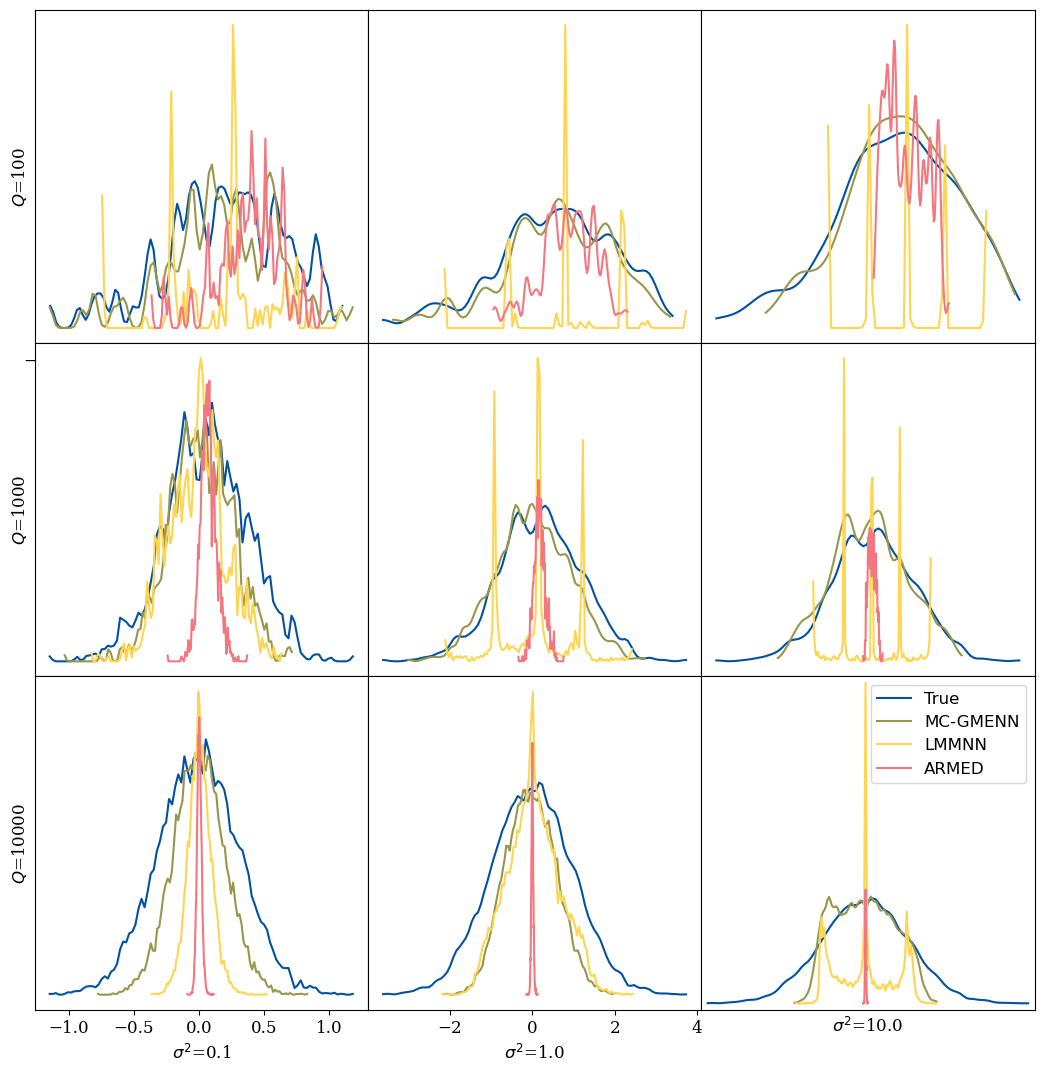

In [29]:
### All scenarios for Appendix
re_diffs = {}
random_effects = {}

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
std_map = {"0.1": 0,"1.0": 1,"10.0": 2,}
q_map = {"100": 0,"1000": 1,"10000": 2,}
for scenario_num, scenario_key in enumerate(scenarios):
    random_effects[scenario_key] = {}
    re_diffs[scenario_key] = {}
    
    std,q = scenario_key.split(",")
    if scenario_num in [0,1,2]:
        axes[q_map[q],std_map[std]].set_ylabel(f"$Q$={scenario_key.split(',')[1]}")
    if scenario_num in [2,5,8]:
        axes[q_map[q],std_map[std]].set_xlabel(f"$\sigma^2$={scenario_key.split(',')[0]}")

    for num in range(iterations):
        if num !=0:
            continue
        random_effects = {model: results[scenario_key][num]["other_info"][model]["random_effects"] for model in ["GMENN", "LMMNN", "ARMED (no adv.)"]}
        learned_stds = {model: results[scenario_key][num]["other_info"][model]["_stddev_z"] for model in ["GMENN", "LMMNN","ARMED (no adv.)"]}

        re = datasets[scenario_key][num][-1][0]
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ",).fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[q_map[q],std_map[std]].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[0])

        re = -1*random_effects["GMENN"][0].numpy().ravel()
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[q_map[q],std_map[std]].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[1])


        re = random_effects["LMMNN"][0]
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[q_map[q],std_map[std]].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[2])


        re = -1*random_effects["ARMED (no adv.)"]
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[q_map[q],std_map[std]].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[3])
        
#         axes[q_map[q],std_map[std]].set_title(f"$\sigma^2$={scenario_key.split(',')[0]}, q={scenario_key.split(',')[1]}")
#         axes[q_map[q],std_map[std]].set_title(f"$\sigma^2$={scenario_key.split(',')[0]}, q={scenario_key.split(',')[1]}")

#         axes[q_map[q],std_map[std]].set_yticks([],[])
        axes[q_map[q],std_map[std]].set(yticks=[])

plt.style.use('default')
# # plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0.02,0.02)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.legend([f"True","MC-GMENN", "LMMNN" ,"ARMED"],loc="upper right")

plt.savefig('learned_re_comparison_all.svg', format='svg',bbox_inches='tight', pad_inches = 0)

plt.show()

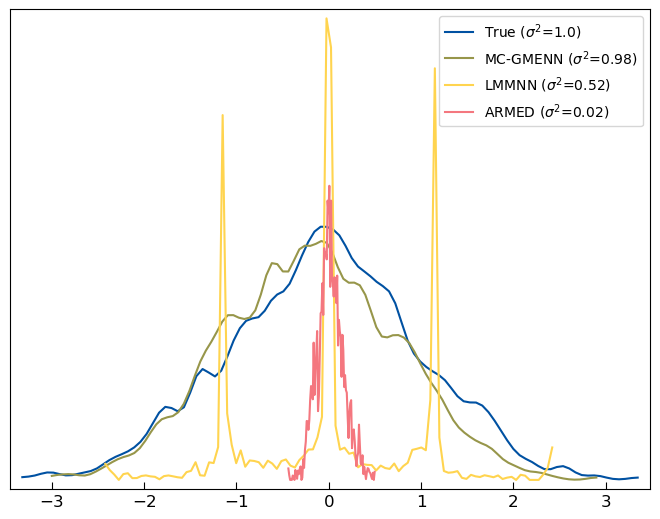

In [30]:
scenario_key = "1.0,1000"
random_effects[scenario_key] = {}
re_diffs[scenario_key] = {}

std,q = scenario_key.split(",")
    
random_effects = {model: results[scenario_key][num]["other_info"][model]["random_effects"] for model in ["GMENN", "LMMNN", "ARMED (no adv.)"]}
learned_stds = {model: results[scenario_key][num]["other_info"][model]["_stddev_z"] for model in ["GMENN", "LMMNN",  "ARMED (no adv.)"]}

re = datasets[scenario_key][num][-1][0]
edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
kde_menn = FFTKDE(kernel='gaussian', bw="ISJ",).fit(re)
probabilities_menn = kde_menn.evaluate(edges_menn)
plt.plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[0])

re = -1*random_effects["GMENN"][0].numpy().ravel()
edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
probabilities_menn = kde_menn.evaluate(edges_menn)
plt.plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[1])


re = random_effects["LMMNN"][0]
edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
probabilities_menn = kde_menn.evaluate(edges_menn)
plt.plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[2])


re = -1*random_effects["ARMED (no adv.)"]
edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
probabilities_menn = kde_menn.evaluate(edges_menn)
plt.plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[3])

# plt.title(f"Learned distribution for $\sigma^2$={scenario_key.split(',')[0]} and q={scenario_key.split(',')[1]}")
plt.legend([f"True ($\sigma^2$={scenario_key.split(',')[0]})", 
            f"MC-GMENN ($\sigma^2$={round(float(learned_stds['GMENN'].ravel()[0])**2,2)})", 
            f"LMMNN ($\sigma^2$={round(float(learned_stds['LMMNN'][1][0])**2,2)})", 
            f"ARMED ($\sigma^2$={round(float(learned_stds['ARMED (no adv.)'])**2,2)})"],
           loc="upper right",  fontsize=10)
plt.yticks([],[])

## From https://towardsdatascience.com/matplotlib-styles-for-scientific-plotting-d023f74515b4
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0

plt.style.use('default')
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0.02,0.02)
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig('learned_re_comparison.svg', format='svg',bbox_inches='tight', pad_inches = 0)
plt.show()




### Learned variance - new

In [31]:
re_stds = {}
for scenario_key in scenarios:
    random_effects[scenario_key] = {}
    re_stds[scenario_key] = {}
    for num in range(iterations):
#         random_effects = {model: results[scenario_key][num]["other_info"][model]["random_effects"] for model in ["GMENN", "LMMNN", "ARMED", "ARMED (no adv.)"]}
        learned_stds = {model: results[scenario_key][num]["other_info"][model]["_stddev_z"] for model in ["GMENN", "LMMNN", "ARMED (no adv.)"]}

#         print(learned_stds["ARMED (no adv.)"],random_effects["ARMED (no adv.)"].std())
        
        re_stds[scenario_key][num] = {"GMENN": round(float(learned_stds['GMENN'].ravel()[0])**2,2), 
                                      "LMMNN": round(float(learned_stds['LMMNN'][1][0]),2), 
                                      "ARMED": round(float(learned_stds['ARMED (no adv.)']),2),
                                      "Embedding": np.nan} 

mean_df_re_stds = pd.DataFrame({scenario_key: pd.DataFrame(re_stds[scenario_key]).mean(axis=1) for scenario_key in scenarios})
mean_df_re_stds
# # Mean reciprocal rank
# print(np.mean((1/mean_df_re_stds.rank(axis=0,ascending=False)),axis=1).round(2))

# # Mean rank
# print(np.mean((mean_df_re_stds.rank(axis=0,ascending=False)),axis=1).round(2))

# # Average distance to best
# print(mean_df_re_stds.apply(lambda x: np.abs(x-np.max(x)),axis=0).mean(axis=1).round(4))


# mean_df_cors

,"0.1,100","0.1,1000","0.1,10000","1.0,100","1.0,1000","1.0,10000","10.0,100","10.0,1000","10.0,10000"
GMENN,0.096,0.096,0.174,0.938,0.988,0.738,8.044,8.840,6.174
LMMNN,0.080,0.096,0.086,0.534,0.656,0.898,2.078,2.426,5.078
ARMED,0.172,0.064,0.020,0.482,0.140,0.020,1.054,0.280,0.040
Embedding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
true_vars = pd.Series(mean_df_re_stds.columns).apply(lambda x: x.split(",")[0]).astype(float).values
(np.abs(mean_df_re_stds-true_vars)/true_vars).mean(axis=1).round(3)

GMENN        0.206
LMMNN        0.370
ARMED        0.789
Embedding      NaN
dtype: float64

In [33]:
true_vars = pd.Series(mean_df_re_stds.columns).apply(lambda x: x.split(",")[0]).astype(float).values
(np.abs(mean_df_re_stds-true_vars)).mean(axis=1).round(4)

GMENN        0.8178
LMMNN        2.3742
ARMED        3.4636
Embedding       NaN
dtype: float64

In [34]:
paper_df.loc['mean($\sigma^2-\hat\sigma^2$)'] = (np.abs(mean_df_re_stds-true_vars)/true_vars).mean(axis=1).round(4)
paper_df

,GMENN,LMMNN,ARMED,TE
Avg. rank (AUC),0.6296,0.6000,0.1598,0.5463
Avg. AUC diff.,0.2122,0.3294,8.1207,0.9275
Avg. train time,0.9243,7.8946,4.8076,1.0301
mean($\sigma^2-\hat\sigma^2$),0.2056,0.3704,0.7890,NaN


In [35]:
print(paper_df.to_latex(index=True))

\begin{tabular}{lrrrr}
\toprule
{} &   GMENN &   LMMNN &   ARMED &      TE \\
\midrule
Avg. rank (AUC)               &  0.6296 &  0.6000 &  0.1598 &  0.5463 \\
Avg. AUC diff.                &  0.2122 &  0.3294 &  8.1207 &  0.9275 \\
Avg. train time               &  0.9243 &  7.8946 &  4.8076 &  1.0301 \\
mean(\$\textbackslash sigma\textasciicircum 2-\textbackslash hat\textbackslash sigma\textasciicircum 2\$) &  0.2056 &  0.3704 &  0.7890 &     NaN \\
\bottomrule
\end{tabular}



In [36]:
models = ["GMENN", "LMMNN", "ARMED"]
# metric = "Time"

#####
dataset_res_dict = {}
best_models = {}
t_test_results = {}

round_mean_at = 2
round_std_at = 3

for dataset_name in scenarios:
    use_df = pd.DataFrame(re_stds[dataset_name]).transpose()[models]
    
    df_mean = pd.DataFrame(use_df.mean(axis=0).round(round_mean_at).astype(str) + " (" + use_df.std(axis=0).round(round_std_at).astype(str) + ")").transpose()
    model_dict = {i: df_mean[i].values[0] for i in df_mean.columns}
    dataset_res_dict[dataset_name] = model_dict
    
    best_models[dataset_name] = use_df.columns[use_df.mean(axis=0).argmin()]

    t_test_res = np.array([stats.ttest_rel(use_df[best_models[dataset_name]].values, use_df[model].values)[1] if model in dataset_models else 0 for model in models]).round(3)
    t_test_res[np.isnan(t_test_res)] = 1.
    t_test_results[dataset_name] = t_test_res
    
res_df_true = pd.DataFrame(dataset_res_dict).transpose()
    
def negative_bold(val):
    i = np.where(val.name==np.array(models))[0][0]
    return ["font-weight: bold"  if t_test_results[dataset_name][i]>=0.05 else "" for dataset_name in val.keys()]
    # Case without transpose:
#     return ["font-weight: bold"  if t_test_results[val.name][i]>=0.05 else "" for i in range(len(val))]

# res_df.style.apply(negative_bold)
res_df_true

,GMENN,LMMNN,ARMED
"0.1,100",0.1 (0.017),0.08 (0.016),0.17 (0.008)
"0.1,1000",0.1 (0.005),0.1 (0.005),0.06 (0.005)
"0.1,10000",0.17 (0.011),0.09 (0.011),0.02 (0.0)
"1.0,100",0.94 (0.086),0.53 (0.021),0.48 (0.013)
"1.0,1000",0.99 (0.09),0.66 (0.052),0.14 (0.0)
"1.0,10000",0.74 (0.027),0.9 (0.038),0.02 (0.0)
"10.0,100",8.04 (0.665),2.08 (0.195),1.05 (0.029)
"10.0,1000",8.84 (0.231),2.43 (0.111),0.28 (0.0)
"10.0,10000",6.17 (0.127),5.08 (0.06),0.04 (0.0)


In [37]:
models = ["GMENN", "LMMNN", "ARMED"]
# metric = "Time"

#####
dataset_res_dict = {}
best_models = {}
t_test_results = {}

round_mean_at = 2
round_std_at = 3

for dataset_name in scenarios:
    use_df = (pd.DataFrame(re_stds[dataset_name]).transpose()[models]-float(dataset_name.split(",")[0])).abs()
    
    df_mean = pd.DataFrame(use_df.mean(axis=0).round(round_mean_at).astype(str) + " (" + use_df.std(axis=0).round(round_std_at).astype(str) + ")").transpose()
    model_dict = {i: df_mean[i].values[0] for i in df_mean.columns}
    dataset_res_dict[dataset_name] = model_dict
    
    best_models[dataset_name] = use_df.columns[use_df.mean(axis=0).argmin()]

    t_test_res = np.array([stats.ttest_rel(use_df[best_models[dataset_name]].values, use_df[model].values)[1] if model in dataset_models else 0 for model in models]).round(3)
    t_test_res[np.isnan(t_test_res)] = 1.
    t_test_results[dataset_name] = t_test_res
    
res_df_diff = pd.DataFrame(dataset_res_dict).transpose()
    
def negative_bold(val):
    i = np.where(val.name==np.array(models))[0][0]
    return ["font-weight: bold"  if t_test_results[dataset_name][i]>=0.05 else "" for dataset_name in val.keys()]
    # Case without transpose:
#     return ["font-weight: bold"  if t_test_results[val.name][i]>=0.05 else "" for i in range(len(val))]


# res_df.style.apply(negative_bold)
res_df_diff

,GMENN,LMMNN,ARMED
"0.1,100",0.01 (0.011),0.02 (0.016),0.07 (0.008)
"0.1,1000",0.0 (0.005),0.0 (0.005),0.04 (0.005)
"0.1,10000",0.07 (0.011),0.01 (0.011),0.08 (0.0)
"1.0,100",0.08 (0.062),0.47 (0.021),0.52 (0.013)
"1.0,1000",0.06 (0.057),0.34 (0.052),0.86 (0.0)
"1.0,10000",0.26 (0.027),0.1 (0.038),0.98 (0.0)
"10.0,100",1.96 (0.665),7.92 (0.195),8.95 (0.029)
"10.0,1000",1.16 (0.231),7.57 (0.111),9.72 (0.0)
"10.0,10000",3.83 (0.127),4.92 (0.06),9.96 (0.0)


In [38]:
res_df_diff.transpose()

,"0.1,100","0.1,1000","0.1,10000","1.0,100","1.0,1000","1.0,10000","10.0,100","10.0,1000","10.0,10000"
GMENN,0.01 (0.011),0.0 (0.005),0.07 (0.011),0.08 (0.062),0.06 (0.057),0.26 (0.027),1.96 (0.665),1.16 (0.231),3.83 (0.127)
LMMNN,0.02 (0.016),0.0 (0.005),0.01 (0.011),0.47 (0.021),0.34 (0.052),0.1 (0.038),7.92 (0.195),7.57 (0.111),4.92 (0.06)
ARMED,0.07 (0.008),0.04 (0.005),0.08 (0.0),0.52 (0.013),0.86 (0.0),0.98 (0.0),8.95 (0.029),9.72 (0.0),9.96 (0.0)


In [39]:
res_df_diff.apply(negative_bold)

,GMENN,LMMNN,ARMED
"0.1,100",font-weight: bold,font-weight: bold,
"0.1,1000",font-weight: bold,font-weight: bold,
"0.1,10000",,font-weight: bold,
"1.0,100",font-weight: bold,,
"1.0,1000",font-weight: bold,,
"1.0,10000",,font-weight: bold,
"10.0,100",font-weight: bold,,
"10.0,1000",font-weight: bold,,
"10.0,10000",font-weight: bold,,


In [40]:
var_df = pd.concat([index_df[['$q$','$\sigma$']], res_df_true],axis=1)
var_df.columns = ["$Q$", "$\sigma^2_{True}$", "$\sigma^2_{MC-GMENN}$", "$\sigma^2_{LMMNN}$", "$\sigma^2_{ARMED}$"]
var_df

,$Q$,$\sigma^2_{True}$,$\sigma^2_{MC-GMENN}$,$\sigma^2_{LMMNN}$,$\sigma^2_{ARMED}$
"0.1,100",100,0.1,0.1 (0.017),0.08 (0.016),0.17 (0.008)
"0.1,1000",1000,0.1,0.1 (0.005),0.1 (0.005),0.06 (0.005)
"0.1,10000",10000,0.1,0.17 (0.011),0.09 (0.011),0.02 (0.0)
"1.0,100",100,1.0,0.94 (0.086),0.53 (0.021),0.48 (0.013)
"1.0,1000",1000,1.0,0.99 (0.09),0.66 (0.052),0.14 (0.0)
"1.0,10000",10000,1.0,0.74 (0.027),0.9 (0.038),0.02 (0.0)
"10.0,100",100,10.0,8.04 (0.665),2.08 (0.195),1.05 (0.029)
"10.0,1000",1000,10.0,8.84 (0.231),2.43 (0.111),0.28 (0.0)
"10.0,10000",10000,10.0,6.17 (0.127),5.08 (0.06),0.04 (0.0)


In [41]:
print(var_df.to_latex(index=False))


\begin{tabular}{rrlll}
\toprule
  \$Q\$ &  \$\textbackslash sigma\textasciicircum 2\_\{True\}\$ & \$\textbackslash sigma\textasciicircum 2\_\{MC-GMENN\}\$ & \$\textbackslash sigma\textasciicircum 2\_\{LMMNN\}\$ & \$\textbackslash sigma\textasciicircum 2\_\{ARMED\}\$ \\
\midrule
  100 &                0.1 &           0.1 (0.017) &       0.08 (0.016) &       0.17 (0.008) \\
 1000 &                0.1 &           0.1 (0.005) &        0.1 (0.005) &       0.06 (0.005) \\
10000 &                0.1 &          0.17 (0.011) &       0.09 (0.011) &         0.02 (0.0) \\
  100 &                1.0 &          0.94 (0.086) &       0.53 (0.021) &       0.48 (0.013) \\
 1000 &                1.0 &           0.99 (0.09) &       0.66 (0.052) &         0.14 (0.0) \\
10000 &                1.0 &          0.74 (0.027) &        0.9 (0.038) &         0.02 (0.0) \\
  100 &               10.0 &          8.04 (0.665) &       2.08 (0.195) &       1.05 (0.029) \\
 1000 &               10.0 &          8.84 (0.231